# Task Description

https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech

The objective of this task is to detect hate speech in tweets. For the sake of simplicity, we say a tweet contains hate speech if it has a racist or sexist sentiment associated with it. So, the task is to classify racist or sexist tweets from other tweets.

Formally, given a training sample of tweets and labels, where label '1' denotes the tweet is racist/sexist and label '0' denotes the tweet is not racist/sexist, the objective is to predict the labels on the test dataset.

# Initial Setup

In [84]:
# Base
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

# Stopwords
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords

# Lemmatisation
from textblob import Word
# nltk.download('wordnet')

# Spelling
from textblob import TextBlob
from textblob import Word

# Other
import re
import string

# ML
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, confusion_matrix, roc_curve, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import ComplementNB, MultinomialNB, BernoulliNB, CategoricalNB, GaussianNB
from sklearn.decomposition import TruncatedSVD 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE, ADASYN

# Interface
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

# Exploratory Data Analysis & Data Preprocessing

In [5]:
df = df_train = pd.read_csv(r'dataset\train.csv', encoding='utf-8')
df_original = df.copy()
display(df_train.head())
print(df_train.shape)

df_test = pd.read_csv(r'dataset\test.csv', encoding='utf-8')
display(df_test.head())
print(df_test.shape)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


(31962, 3)


,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


(17197, 2)


The train dataset has 31962 records with only two meaningful columns: 'label' representing target variable value ('1' is a racist/sexist tweet, whereas '0' is not) and 'tweet' with the text to analyse. 

The test dataset does not contain any information on the target variable. As I understood, it was a test dataset from a past Kaggle competition. It does not have any meaning without the 'label' column, so in the following analysis, I am going to work with the train part only.

In [7]:
df.info()
# NaN values are absent

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [8]:
df['label'].value_counts(normalize=True)
# Target variable is heavily imbalanced

label
0    0.929854
1    0.070146
Name: proportion, dtype: float64

In [9]:
# Checking for duplicates
print(f'Number of duplicates: {len(df[df.duplicated(subset='tweet')])}')

Number of duplicates: 2432


In [10]:
# There are quite a lot of identical tweets. 
# It may be mistakes in the dataset or a flashmob by tweeter users (see an example below). 
# Anyways, for us duplicates are redundant.
df[df['tweet']==df.loc[3]['tweet']]

,id,label,tweet
3,4,0,#model i love u take with u all the time in ...
46,47,0,#model i love u take with u all the time in ...
96,97,0,#model i love u take with u all the time in ...
117,118,0,#model i love u take with u all the time in ...
162,163,0,#model i love u take with u all the time in ...
...,...,...,...
31216,31217,0,#model i love u take with u all the time in ...
31461,31462,0,#model i love u take with u all the time in ...
31475,31476,0,#model i love u take with u all the time in ...
31496,31497,0,#model i love u take with u all the time in ...


In [11]:
# Dropping duplicates
df.drop_duplicates(subset='tweet', keep='first', inplace=True, ignore_index=True)

print(f'Shape after duplicates dropping: {df.shape}')

Shape after duplicates dropping: (29530, 3)


In [12]:
# Dropping the 'id' column as meaningless
df.drop(columns='id', inplace=True)

In [13]:
# A lot of messages contain escape characters and special symbols which are,
# obviously, emojis and should be decoded properly as they may help us label tweets more precisely
display(df.loc[3]['tweet'])
display(df.loc[3]['tweet'].encode('latin1').decode('utf-8'))

'#model   i love u take with u all the time in urð\x9f\x93±!!! ð\x9f\x98\x99ð\x9f\x98\x8eð\x9f\x91\x84ð\x9f\x91\x85ð\x9f\x92¦ð\x9f\x92¦ð\x9f\x92¦  '

'#model   i love u take with u all the time in ur📱!!! 😙😎👄👅💦💦💦  '

In [14]:
# Let us clean up the tweets
def process_tweet(tweet: str) -> str:
    # Removing non-breaking spaces and some other symbols
    tweet = tweet.replace(' \xa0', ' ')
    tweet = tweet.replace('&gt;', '>')
    tweet = tweet.replace('_', ' ')

    # Decoding emojis
    tweet = tweet.encode('latin1').decode('utf-8') 

    # Finding all emojis in the tweet and separating them by a whitespace
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # Emoticons
        "\U0001F300-\U0001F5FF"  # Symbols & Pictographs
        "\U0001F680-\U0001F6FF"  # Transport & Map Symbols
        "\U0001F700-\U0001F77F"  # Alchemical Symbols
        "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
        "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
        "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        "\U0001FA00-\U0001FA6F"  # Chess Symbols
        "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        "\U00002702-\U000027B0"  # Dingbats
        "\U000024C2-\U0001F251"  # Enclosed Characters
        "]", flags=re.UNICODE)
    emojis = set(emoji_pattern.findall(tweet))
    
    for emoji in emojis:
        tweet = tweet.replace(emoji, ' ' + emoji + ' ')

    # Separating hashtags with whitespaces, lowering all words
    tweet = tweet.replace('#', ' #')
    tweet = tweet.lower()

    # Removing numbers
    tweet = re.sub(r'\d', '', tweet)

    # Replacing some internet slang    
    slang_dict = {
        'u': 'you',
        'im': 'i am',
        'ur': 'your',
        'y': 'why',
        'yo': 'hey',
        'u2': 'you too',
        'yr': 'your',
        'yu': 'you',
        'r': 'are',
        'cant': 'can not',
        "can't": 'can not',
        'urself': 'yourself',
        'kno': 'know',
        'b': 'be',
        "u'll": 'you will',
        'yup': 'yes',
        'ya': 'you',
        'yuh': 'yes',
    }

    slang_pattern = re.compile(r'\b(' + '|'.join(map(re.escape, slang_dict.keys())) + r')\b')
    tweet = slang_pattern.sub(lambda match: slang_dict[match.group(0)], tweet)

    # Removing stopwords
    tweet = ' '.join([word for word in tweet.split() if word not in stopwords.words("english")])
    
    # Counting the number of punctuation marks (they can indicate emotional coloring of the tweet) 
    # and removing them from the tweet
    punctuation_counter = ''
    for punctuation_mark in string.punctuation + '…':
        n = tweet.count(punctuation_mark)
        punctuation_counter += str(n) + ' '
        tweet = tweet.replace(punctuation_mark, '')
        # Let us have a look at tweets with many punctuation marks
        if n > 20: print(f'Tweet with {n} "{punctuation_mark}" symbols:\n{tweet}\n')
    punctuation_counter = punctuation_counter.strip()    
    
    # Stripping and removing extra whitespaces
    tweet = tweet.strip()
    tweet = ' '.join(tweet.split())

    # Lemmatisation of nouns and verbs
    tweet = " ".join([Word(word).lemmatize('n') for word in tweet.split()])
    tweet = " ".join([Word(word).lemmatize('v') for word in tweet.split()])
    
    return tweet, punctuation_counter

df[['tweet','punctuation']] = pd.DataFrame(df['tweet'].apply(process_tweet).tolist(), index=df.index)

# Adding columns with the number of punctuation marks
df = pd.concat([df, df['punctuation'].str.split(expand=True)], axis=1)
df.drop(columns='punctuation', inplace=True)
df.columns = ['label', 'tweet'] + list((string.punctuation + '…').strip(''))

# Dropping columns with 0's
for column in df.columns:
    if df[column].max() == '0':
        df.drop(columns=column, inplace=True) 
    elif column in string.punctuation + '…':
        df[column] = df[column].astype(int)

Tweet with 58 "!" symbols:
#omg #orangeisthenewblack took days. finished. cried eyes off 

Tweet with 21 "." symbols:
today exam system anaylsis design   sho form  :   bc sach bhot hu me : :p

Tweet with 22 "." symbols:
city dreams manila where sun  ganda

Tweet with 23 "." symbols:
greatest gift ever came god  call dad  fathers day love dad 

Tweet with 22 "…" symbols:
tuesdaymotivation truth  back success                      

Tweet with 36 ">" symbols:
  二 宮 和 也 bihday to you  愛 を 叫 べ  歳 …



In [15]:
df.drop(columns=['label', 'tweet']).max()

!    58
"     6
#    20
$     3
%     6
&     7
'     9
(    11
)     6
*    18
+     8
,    16
-    14
.    23
/     5
:     8
;     7
=     5
>    36
?    12
@    11
[     2
\     1
]     2
^     7
`     2
{     1
|     9
}     1
~     5
…    22
dtype: int32

As we can see, some tweets contain many punctuation marks and they are very emotional.

In [17]:
df.describe()

,label,!,"""",#,$,%,&,',(,),*,+,",",-,.,/,:,;,=,>,?,@,[,\,],^,`,{,|,},~,…
count,29530.000000,29530.000000,29530.000000,29530.000000,29530.000000,29530.000000,29530.000000,29530.000000,29530.000000,29530.000000,29530.000000,29530.000000,29530.000000,29530.000000,29530.000000,29530.000000,29530.000000,29530.000000,29530.000000,29530.000000,29530.000000,29530.000000,29530.000000,29530.000000,29530.000000,29530.000000,29530.000000,29530.000000,29530.000000,29530.000000,29530.000000,29530.000000
mean,0.068168,0.424958,0.059431,2.376465,0.005418,0.007619,0.062513,0.162513,0.025432,0.034372,0.008195,0.006062,0.208703,0.094751,0.793498,0.024585,0.091432,0.068845,0.005486,0.007281,0.081206,0.604030,0.003217,0.000508,0.003115,0.001896,0.000305,0.000339,0.006603,0.000203,0.005249,0.159499
std,0.252038,1.068899,0.356490,2.533516,0.090366,0.129771,0.291003,0.453205,0.189098,0.216814,0.177086,0.109478,0.603105,0.424650,1.415563,0.182560,0.322286,0.306003,0.095819,0.238483,0.369301,1.004762,0.057813,0.022533,0.057524,0.071721,0.022536,0.018399,0.124228,0.014253,0.090188,0.399666
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,58.000000,6.000000,20.000000,3.000000,6.000000,7.000000,9.000000,11.000000,6.000000,18.000000,8.000000,16.000000,14.000000,23.000000,5.000000,8.000000,7.000000,5.000000,36.000000,12.000000,11.000000,2.000000,1.000000,2.000000,7.000000,2.000000,1.000000,9.000000,1.000000,5.000000,22.000000


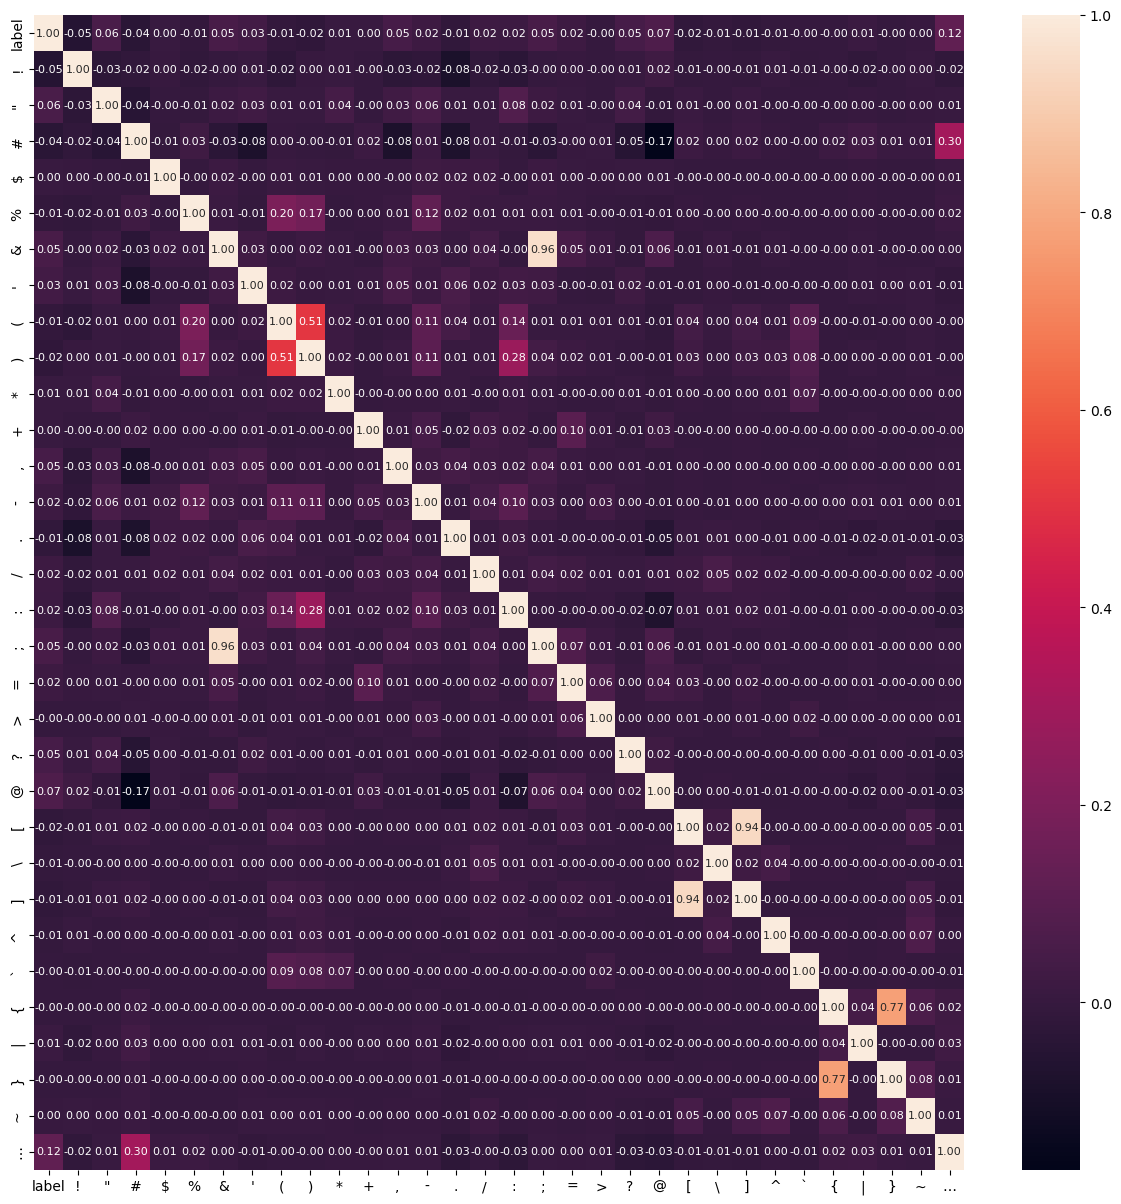

In [18]:
# Let us have a look if there is any correlation between 'label' and punctuation marks
figure(figsize=(15, 15))
sns.heatmap(df.corr(numeric_only=True), annot=True, annot_kws={"size": 8}, fmt='.2f');

There is no noticeable correlation at all. Apparently, punctuation marks are useless to us.

In [21]:
# Let us take a look at how accurate the spelling correction is
for i in range(10):
    print(f"Original tweet:\n{df_original.loc[i]['tweet']}\n")
    blob = TextBlob(df.loc[i]['tweet'])
    print(f"After spelling correction:\n{blob.correct()}")
    print('-'*20)

Original tweet:
 @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run

After spelling correction:
user father dysfunctional selfish drag kid dysfunction run
--------------------
Original tweet:
@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked

After spelling correction:
user user thank left credit use cause offer wheelchair van pox disappointed getthanked
--------------------
Original tweet:
  bihday your majesty

After spelling correction:
midday majesty
--------------------
Original tweet:
#model   i love u take with u all the time in urð±!!! ððððð¦ð¦ð¦  

After spelling correction:
model love take time 📱 😙 😎 👄 👅 💦 💦 💦
--------------------
Original tweet:
 factsguide: society now    #motivation

After spelling correction:
factsguide society motivation
--------------------
Original tweet:
[2/2] huge fan fare and big talking before they leave. c

Autocorrection changes letters in hashtags and doesn't perform correctly enough. This may distort the meaning of tweets, so I would rather leave it in its initial state.

## Conclusion

As vectorisation is performed further, not much can be infered based on the data we obtained so far:

1. Target variable is heavily imbalanced and may require proper handling. 
2. Emoji present in tweets can potentially help us in our further analysis.
3. There is no noticeable correlation between punctuation marks and target value.

# Naive Bayes Classifier with the Bag of Words

Instead of using in-built pipeline and grid search, I decided to iterate through parameters manually to be able to observe and analyse intermediate results. This is implemented with the utilisation of classes.

Given that handling imbalanced classes is not the main focus of this task, I will use only a few algorithms for it.

In [30]:
class BayesNLP:
    def __init__(self, df: pd.DataFrame, cv: int = 5):
        self._df = df.sample(frac=1, random_state=42, ignore_index=True)
        self._x = self._df['tweet']
        self._y = self._df['label']
        self.train_test_split_cv(cv=cv)

    
    def train_test_split_cv(self, cv):
        '''
        A function that splits the dataset into several parts (cv) for further cross-validation.
        '''
        self._cv = cv
        self._x_test = []
        self._y_test = []
        self._x_train = []
        self._y_train = []

        start_index = 0
        end_index = len(self._df) // cv
        for i in range(cv):
            start_index = len(self._df) // cv * i
            end_index = len(self._df) // cv * (i + 1) - 1
            
            self._x_test.append(df['tweet'].loc[start_index:end_index])
            self._y_test.append(df['label'].loc[start_index:end_index])
            self._x_train.append(df['tweet'].drop(df.index[start_index:end_index]))
            self._y_train.append(df['label'].drop(df.index[start_index:end_index]))

    
    def grid_search_cv(self, 
                       classifiers = [MultinomialNB],
                       classifier_param_grids = [{}],
                       vectorizer = CountVectorizer,
                       vectorizer_param_grid = {},
                       imbalance_algorithm = None):
        '''
        A function that implements grid search with cross-validation using a passed classifier and vectoriser
        (without instantiating) and parameters for them in separate variables. 
        SMOTE or ADASYN should be passed already with parameters
        '''
        self._classifiers = classifiers
        self._classifier_param_grids = classifier_param_grids
        self._vectorizer = vectorizer
        self._vectorizer_param_grid = vectorizer_param_grid  
        self._imbalance_algorithm = imbalance_algorithm

        # Counter to see the progress
        self._number_of_iterations = 0
        for k in range(len(classifier_param_grids)):
            n = 1
            for param in classifier_param_grids[k]:
                n *= len(classifier_param_grids[k][param]) 
            for param in vectorizer_param_grid:
                n *= len(vectorizer_param_grid[param])  
            self._number_of_iterations += n
            
        self._iteration = 0
        print(f'Total number of iterations: {self._number_of_iterations}.')
                
        # An empty dataframe for average results of cross-validation with different parameters
        self._cv_results = pd.DataFrame(columns=['vectorizer', 'vectorizer_params', 'imbalance_algorithm', 'classifier', 'classifier_params', 
                                                 'accuracy', 'precision', 'recall', 'roc_auc', 'f1', 
                                                 'TN_real0_pred0', 'FP_real0_pred1',
                                                 'FN_real1_pred0', 'TP_real1_pred1', 
                                                 'pos_words', 'neg_words'])

        # Iterating through each classifier
        for k in range(len(classifiers)):
            self.vectorizer_param_grid_iterator(vectorizer_param_grid, k=k)
        

    def vectorizer_param_grid_iterator(self, vectorizer_param_grid, k, j = 0, vectorizer_current_params = {}):
        '''
        A function iterating through vectoriser parameters for grid search via recursion
        'j' is the number of a current parameter
        'k' is the number of a current classifier
        '''
        # Iterating through all values of j-parameter and adding them to a dictionary
        for param in vectorizer_param_grid[list(vectorizer_param_grid.keys())[j]]:
            vectorizer_current_params[list(vectorizer_param_grid.keys())[j]] = param

            # Calling the function itself if there are more parameters left
            if j < len(vectorizer_param_grid) - 1:
                self.vectorizer_param_grid_iterator(vectorizer_param_grid, 
                                                    j=j+1, 
                                                    vectorizer_current_params=vectorizer_current_params, 
                                                    k=k)

            # If no more parameters left, calling a function for 
            # vectorisation with the current set of parameters
            else:
                self.vectorize(vectorizer=self._vectorizer, 
                               vectorizer_current_params=vectorizer_current_params, 
                               imbalance_algorithm=self._imbalance_algorithm,
                               classifier=self._classifiers[k],
                               classifier_param_grid=self._classifier_param_grids[k])


    def vectorize(self, 
                  vectorizer = CountVectorizer, 
                  vectorizer_current_params = {}, 
                  imbalance_algorithm = None, 
                  classifier = MultinomialNB,
                  classifier_param_grid = {}):
        '''
        A function that applies a certain vectoriser with a certain set of parameters
        '''
        
        vectorizer_with_current_params = vectorizer(**vectorizer_current_params)
        vectorizer_with_current_params.fit(self._x)
        self._x_train_vec = []
        self._x_test_vec = []
        self._x_train_vec_balanced = []
        self._y_train_balanced = []
        for i in range(self._cv):
            self._x_train_vec.append(vectorizer_with_current_params.transform(self._x_train[i]))
            self._x_test_vec.append(vectorizer_with_current_params.transform(self._x_test[i]))

            # Hadling the imbalance
            if self._imbalance_algorithm:
                x_train_vec_balanced_i, y_train_balanced_i = imbalance_algorithm.fit_resample(self._x_train_vec[i], self._y_train[i]) 
                self._x_train_vec_balanced.append(x_train_vec_balanced_i)
                self._y_train_balanced.append(y_train_balanced_i)
            else:
                self._x_train_vec_balanced = self._x_train_vec.copy()
                self._y_train_balanced = self._y_train.copy()

        # If no parameters for grid search passed, then perfroming only cross-validation with 
        # default parameters of the classifier
        if classifier_param_grid == {}:
            self.cross_val(classifier=classifier, 
                           classifier_current_params={}, 
                           vectorizer_current_params=vectorizer_current_params,
                           vectorizer_with_current_params=vectorizer_with_current_params)
        else:
            self.classifier_param_grid_iterator(classifier, 
                                                classifier_param_grid, 
                                                vectorizer_current_params=vectorizer_current_params, 
                                                vectorizer_with_current_params=vectorizer_with_current_params)

    
    def classifier_param_grid_iterator(self, 
                                       classifier, 
                                       classifier_param_grid, 
                                       vectorizer_with_current_params, 
                                       j = 0, 
                                       classifier_current_params = {}, 
                                       vectorizer_current_params = {}):
        '''
        A function iterating through classifier parameters for grid search via recursion
        'j' is the number of a current parameter
        '''
        if j == 0:
            classifier_current_params = {}
        
        # Iterating through all values of j-parameter and adding them to a dictionary
        for param in classifier_param_grid[list(classifier_param_grid.keys())[j]]:
            classifier_current_params[list(classifier_param_grid.keys())[j]] = param

            # Calling the function itself if there are more parameters left
            if j < len(classifier_param_grid) - 1:
                self.classifier_param_grid_iterator(classifier, 
                                                    classifier_param_grid, 
                                                    j = j+1, 
                                                    classifier_current_params=classifier_current_params, 
                                                    vectorizer_current_params=vectorizer_current_params, 
                                                    vectorizer_with_current_params=vectorizer_with_current_params)

            # If no more parameters left, calling a function for 
            # cross-validation with the current set of parameters
            else:
                self.cross_val(classifier,
                               classifier_current_params=classifier_current_params, 
                               vectorizer_current_params=vectorizer_current_params, 
                               vectorizer_with_current_params=vectorizer_with_current_params)

    
    def top_words(self, classifier, vectorizer, n):
        '''
        A function that returns most frequent words in pos and neg category for the current cross-validation fold
        '''
        categories = ('pos', 'neg')
        # Obtaining words back from the vectorizer
        feature_names = np.asarray(vectorizer.get_feature_names_out())
        
        # Selecting the highest probabilities
        top_pos = np.argsort(classifier.feature_log_prob_[0])[-n:]
        pos_words = feature_names[top_pos]
        
        top_neg = np.argsort(classifier.feature_log_prob_[1])[-n:]
        neg_words = feature_names[top_neg]

        return pos_words, neg_words
    
    
    def cross_val(self, classifier, vectorizer_with_current_params, 
                  classifier_current_params = {}, vectorizer_current_params = {}):
        '''
        A fuction that performs cross-validation with a certain set of parameters
        '''
        accuracy = []
        precision = []
        recall = []
        roc_auc = []
        f1 = []
        TN = []
        FN = []
        FP = []
        TP = []
        pos_words = set()
        neg_words = set()
        for i in range(self._cv):
            # CategoricalNB and GaussianNB work only with Numpy arrays and matrices
            if classifier == CategoricalNB or classifier == GaussianNB:
                clf = classifier(**classifier_current_params).fit(self._x_train_vec_balanced[i].toarray(), self._y_train_balanced[i])
                y_predicted = clf.predict(self._x_test_vec[i].toarray())
            else:    
                clf = classifier(**classifier_current_params).fit(self._x_train_vec_balanced[i], self._y_train_balanced[i])
                y_predicted = clf.predict(self._x_test_vec[i])
            
            # Saving metrics for each split
            accuracy.append(accuracy_score(self._y_test[i], y_predicted))
            precision.append(precision_score(self._y_test[i], y_predicted))
            recall.append(recall_score(self._y_test[i], y_predicted))
            roc_auc.append(roc_auc_score(self._y_test[i], y_predicted))
            f1.append(f1_score(self._y_test[i], y_predicted))
            TN.append(confusion_matrix(self._y_test[i], y_predicted)[0, 0])
            FP.append(confusion_matrix(self._y_test[i], y_predicted)[0, 1])
            FN.append(confusion_matrix(self._y_test[i], y_predicted)[1, 0])
            TP.append(confusion_matrix(self._y_test[i], y_predicted)[1, 1])

            # Saving most frequent words in each category
            pos_words_i, neg_words_i = self.top_words(clf, vectorizer_with_current_params, 20)
            pos_words.update(set(pos_words_i))
            neg_words.update(set(neg_words_i)) 

        # Adding average values of metrics to the dataframe with results
        accuracy = round(np.mean(accuracy), 3)
        precision = round(np.mean(precision), 3)
        recall = round(np.mean(recall), 3)
        roc_auc = round(np.mean(roc_auc), 3)
        f1 = round(np.mean(f1), 3)
        TN = round(np.mean(TN))
        FP = round(np.mean(FP))
        FN = round(np.mean(FN))
        TP = round(np.mean(TP))
        
        # Normalising ratios
        real_neg = TN + FP
        real_pos = FN + TP
        TN = round(TN / real_neg, 2)
        FP = round(FP / real_neg, 2)
        FN = round(FN / real_pos, 2)
        TP = round(TP / real_pos, 2)    
       
        cv_results_new_line = pd.DataFrame(data={'vectorizer': [str(self._vectorizer).split('.')[-1][:-2]],
                                                'vectorizer_params': [vectorizer_current_params.copy()],
                                                'imbalance_algorithm': str(self._imbalance_algorithm),
                                                'classifier': [str(classifier).split('.')[-1][:-2]],
                                                'classifier_params': [classifier_current_params.copy()],
                                                'accuracy': [accuracy],
                                                'precision': [precision],
                                                'recall': [recall],
                                                'roc_auc': [roc_auc],
                                                'f1': [f1],
                                                'TN_real0_pred0': [TN],
                                                'FP_real0_pred1': [FP],
                                                'FN_real1_pred0': [FN],
                                                'TP_real1_pred1': [TP],
                                                'pos_words': [pos_words],
                                                'neg_words': [neg_words]}) 
        # Incrementing the general iterator
        self._iteration += 1
        print(f'Iteration {self._iteration} out of {self._number_of_iterations} is finished.')
        if self._iteration == self._number_of_iterations:
            print('-'*35)
        self._cv_results = pd.concat([self._cv_results, cv_results_new_line], ignore_index=True)
               


In [31]:
# Including emojis to the vectoriser pattern
token_pattern = (
    r'(?u)\b\w\w+\b'  # Default pattern for words
    r'|[\U0001F600-\U0001F64F]'  # Emoticons
    r'|[\U0001F300-\U0001F5FF]'  # Symbols & Pictographs
    r'|[\U0001F680-\U0001F6FF]'  # Transport & Map Symbols
    r'|[\U0001F700-\U0001F77F]'  # Alchemical Symbols
    r'|[\U0001F780-\U0001F7FF]'  # Geometric Shapes Extended
    r'|[\U0001F800-\U0001F8FF]'  # Supplemental Arrows-C
    r'|[\U0001F900-\U0001F9FF]'  # Supplemental Symbols and Pictographs
    r'|[\U0001FA00-\U0001FA6F]'  # Chess Symbols
    r'|[\U0001FA70-\U0001FAFF]'  # Symbols and Pictographs Extended-A
    r'|[\U00002702-\U000027B0]'  # Dingbats
    r'|[\U000024C2-\U0001F251]'  # Enclosed Characters
)

In [32]:
# Let us use several classifiers at once iterating through some of their parameters
classifiers = [MultinomialNB,
              ComplementNB,
              BernoulliNB]
              # I also tried CategoricalNB and GaussianNB, but they work only with Numpy arrays which resulted in the 
              # MemoryError: Unable to allocate 7.89 GiB for an array with shape (25571, 41392) and data type int64.
              # Chanding the data type didn't help.

classifier_param_grids = [{'alpha': [1.0, 2.0, 3.0],
                         'fit_prior': [True, False]},
                         
                         {'alpha': [1.0, 2.0, 3.0]},
                         
                         {'alpha': [1.0, 2.0, 3.0],
                         'fit_prior': [True, False],
                         'binarize': [None, 0.0, 0.5]}]

vectorizer_param_grid = {'binary': [True, False],
                         'ngram_range': [(1,1), (1,2)],
                         'token_pattern': [token_pattern]}

In [52]:
# Running the grid search with cross-validation for CountVectorizer without class balancing, with SMOTE and with ADASYN
imbalance_algorithms = [None, SMOTE(random_state=42), ADASYN(random_state=42)]
bayes = {}
keys = ['imbalanced', 'smote', 'adasyn']
results = pd.DataFrame()

for i in range(len(imbalance_algorithms)):
    bayes[keys[i]] = BayesNLP(df, cv=5)
    bayes[keys[i]].grid_search_cv(classifiers = classifiers,
                         classifier_param_grids = classifier_param_grids,
                         vectorizer = CountVectorizer,
                         vectorizer_param_grid = vectorizer_param_grid,
                         imbalance_algorithm = imbalance_algorithms[i])
    results = pd.concat([results, bayes[keys[i]]._cv_results], ignore_index=True)

Total number of iterations: 108.
Iteration 1 out of 108 is finished.
Iteration 2 out of 108 is finished.
Iteration 3 out of 108 is finished.
Iteration 4 out of 108 is finished.
Iteration 5 out of 108 is finished.
Iteration 6 out of 108 is finished.
Iteration 7 out of 108 is finished.
Iteration 8 out of 108 is finished.
Iteration 9 out of 108 is finished.
Iteration 10 out of 108 is finished.
Iteration 11 out of 108 is finished.
Iteration 12 out of 108 is finished.
Iteration 13 out of 108 is finished.
Iteration 14 out of 108 is finished.
Iteration 15 out of 108 is finished.
Iteration 16 out of 108 is finished.
Iteration 17 out of 108 is finished.
Iteration 18 out of 108 is finished.
Iteration 19 out of 108 is finished.
Iteration 20 out of 108 is finished.
Iteration 21 out of 108 is finished.
Iteration 22 out of 108 is finished.
Iteration 23 out of 108 is finished.
Iteration 24 out of 108 is finished.
Iteration 25 out of 108 is finished.
Iteration 26 out of 108 is finished.
Iteration 27 o

In [105]:
# Saving the results so that there is no need to run the algorithm again
results.to_csv('results_countvectorizer.csv', index=False)
results = pd.read_csv('results_countvectorizer.csv')
results

,vectorizer,vectorizer_params,imbalance_algorithm,classifier,classifier_params,accuracy,precision,recall,roc_auc,f1,TN_real0_pred0,FP_real0_pred1,FN_real1_pred0,TP_real1_pred1,pos_words,neg_words
0,CountVectorizer,"{'binary': True, 'ngram_range': (1, 1), 'token...",NaN,MultinomialNB,"{'alpha': 1.0, 'fit_prior': True}",0.944,0.620,0.479,0.729,0.540,0.98,0.02,0.52,0.48,"{'get', 'people', 'see', 'make', 'life', 'user...","{'call', 'trump', 'get', 'people', 'make', 'ra..."
1,CountVectorizer,"{'binary': True, 'ngram_range': (1, 1), 'token...",NaN,MultinomialNB,"{'alpha': 1.0, 'fit_prior': False}",0.913,0.414,0.659,0.795,0.508,0.93,0.07,0.34,0.66,"{'get', 'people', 'see', 'make', 'life', 'user...","{'call', 'trump', 'get', 'people', 'make', 'ra..."
2,CountVectorizer,"{'binary': True, 'ngram_range': (1, 1), 'token...",NaN,MultinomialNB,"{'alpha': 2.0, 'fit_prior': True}",0.944,0.740,0.278,0.636,0.404,0.99,0.01,0.72,0.28,"{'get', 'people', 'see', 'make', 'life', 'user...","{'call', 'trump', 'get', 'people', 'make', 'ra..."
3,CountVectorizer,"{'binary': True, 'ngram_range': (1, 1), 'token...",NaN,MultinomialNB,"{'alpha': 2.0, 'fit_prior': False}",0.932,0.504,0.481,0.723,0.492,0.97,0.03,0.52,0.48,"{'get', 'people', 'see', 'make', 'life', 'user...","{'call', 'trump', 'get', 'people', 'make', 'ra..."
4,CountVectorizer,"{'binary': True, 'ngram_range': (1, 1), 'token...",NaN,MultinomialNB,"{'alpha': 3.0, 'fit_prior': True}",0.941,0.790,0.184,0.590,0.297,1.00,0.00,0.82,0.18,"{'get', 'people', 'see', 'make', 'life', 'user...","{'call', 'trump', 'get', 'people', 'make', 'ra..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,CountVectorizer,"{'binary': False, 'ngram_range': (1, 2), 'toke...",ADASYN(random_state=42),BernoulliNB,"{'alpha': 3.0, 'fit_prior': True, 'binarize': ...",0.642,0.149,0.901,0.762,0.255,0.62,0.38,0.10,0.90,"{'get', 'people', 'see', 'make', 'life', 'user...","{'call', 'trump', 'get', 'people', 'white', 'r..."
320,CountVectorizer,"{'binary': False, 'ngram_range': (1, 2), 'toke...",ADASYN(random_state=42),BernoulliNB,"{'alpha': 3.0, 'fit_prior': True, 'binarize': ...",0.642,0.149,0.901,0.762,0.255,0.62,0.38,0.10,0.90,"{'get', 'people', 'see', 'make', 'life', 'user...","{'call', 'trump', 'get', 'people', 'white', 'r..."
321,CountVectorizer,"{'binary': False, 'ngram_range': (1, 2), 'toke...",ADASYN(random_state=42),BernoulliNB,"{'alpha': 3.0, 'fit_prior': False, 'binarize':...",0.651,0.152,0.901,0.767,0.260,0.63,0.37,0.10,0.90,"{'get', 'see', 'make', 'life', 'user', 'go', '...","{'call', 'trump', 'get', 'people', 'white', 'r..."
322,CountVectorizer,"{'binary': False, 'ngram_range': (1, 2), 'toke...",ADASYN(random_state=42),BernoulliNB,"{'alpha': 3.0, 'fit_prior': False, 'binarize':...",0.642,0.149,0.902,0.762,0.256,0.62,0.38,0.10,0.90,"{'get', 'people', 'see', 'make', 'life', 'user...","{'call', 'trump', 'get', 'people', 'white', 'r..."


Eventually, we obtained a dataframe with parameters of each algorithm, resulting metrics, TN, FN, TP, FP rates and most probable words.

## Analysis of Results

In [84]:
# First of all, let us have a look at most probable positive and negative words
print(f'Positive words: {results.loc[10]['pos_words']}\n')
print(f'Negative words: {results.loc[10]['neg_words']}')

Positive words: {'get', 'people', 'see', 'make', 'life', 'user', 'go', 'amp', 'good', '️', 'love', 'smile', 'happy', 'father', 'time', 'user user', 'one', 'like', 'new', 'day', 'im', 'today'}

Negative words: {'call', 'trump', 'get', 'people', 'make', 'racist', 'white', 'hate', 'woman', 'think', 'go', 'black', 'amp', 'user allahsoil', 'obama', 'say', 'user user', 'like', 'racism', 'allahsoil', 'user', 'be'}


Indeed, as we can see, positive tweets often include such words as smile, love, happy, like, life, etc.

Whereas, negative tweets incorporate hate, racism, allahsoil, black, trump, and so on.

In our task, accuracy is not the most representative metrics, so we need to rely more on other metrics like recall, precision, etc.

In [133]:
results[results['recall'] == results['recall'].max()].head(1)

,vectorizer,vectorizer_params,imbalance_algorithm,classifier,classifier_params,accuracy,precision,recall,roc_auc,f1,TN_real0_pred0,FP_real0_pred1,FN_real1_pred0,TP_real1_pred1,pos_words,neg_words
211,CountVectorizer,"{'binary': False, 'ngram_range': (1, 2), 'toke...",SMOTE(random_state=42),BernoulliNB,"{'alpha': 3.0, 'fit_prior': True, 'binarize': ...",0.641,0.149,0.904,0.763,0.256,0.62,0.38,0.1,0.9,"{'get', 'people', 'see', 'make', 'life', 'user...","{'trump', 'people', 'listen', 'racist', 'white..."


The highest recall of 0.904 is reached using 
BernoulliNB classifier {'alpha': 3.0, 'fit_prior': True, 'binarize': 0.0}, 
CountVectorizer {'binary': False, 'ngram_range': (1, 2)} ('token_pattern' included emoji), 
and SMOTE(random_state=42). 

This algorithm recognises the largest share of negative tweets of 90% (TP).

At the same time, its precision is unacceptably low at 0.149 with the very high percentage of type I mistakes 38% (FP). Such an algorithm cannot be used in practice.

In [167]:
results[(results['classifier'] == 'BernoulliNB') & (results['precision'] > 0.4)].sort_values('recall', ascending=False).head(2)

,vectorizer,vectorizer_params,imbalance_algorithm,classifier,classifier_params,accuracy,precision,recall,roc_auc,f1,TN_real0_pred0,FP_real0_pred1,FN_real1_pred0,TP_real1_pred1,pos_words,neg_words
75,CountVectorizer,"{'binary': False, 'ngram_range': (1, 1), 'toke...",NaN,BernoulliNB,"{'alpha': 1.0, 'fit_prior': False, 'binarize':...",0.939,0.785,0.141,0.569,0.238,1.0,0.0,0.86,0.14,"{'get', 'see', 'make', 'life', 'user', 'go', '...","{'call', 'trump', 'get', 'people', 'make', 'ra..."
39,CountVectorizer,"{'binary': True, 'ngram_range': (1, 1), 'token...",NaN,BernoulliNB,"{'alpha': 1.0, 'fit_prior': False, 'binarize':...",0.939,0.827,0.128,0.563,0.221,1.0,0.0,0.87,0.13,"{'get', 'people', 'see', 'make', 'life', 'user...","{'call', 'trump', 'get', 'people', 'make', 'ra..."


As we can see from the table above, BernoulliNB classifier does not allow us to obtain any high recall along with appropriate precision at all.

In [187]:
results[(results['precision'] > 0.4)].sort_values('recall', ascending=False).head(5)

,vectorizer,vectorizer_params,imbalance_algorithm,classifier,classifier_params,accuracy,precision,recall,roc_auc,f1,TN_real0_pred0,FP_real0_pred1,FN_real1_pred0,TP_real1_pred1,pos_words,neg_words
217,CountVectorizer,"{'binary': True, 'ngram_range': (1, 1), 'token...",ADASYN(random_state=42),MultinomialNB,"{'alpha': 1.0, 'fit_prior': False}",0.909,0.407,0.737,0.829,0.524,0.92,0.08,0.26,0.74,"{'get', 'people', 'see', 'make', 'life', 'user...","{'call', 'trump', 'get', 'people', 'white', 'r..."
216,CountVectorizer,"{'binary': True, 'ngram_range': (1, 1), 'token...",ADASYN(random_state=42),MultinomialNB,"{'alpha': 1.0, 'fit_prior': True}",0.908,0.406,0.737,0.829,0.523,0.92,0.08,0.26,0.74,"{'get', 'people', 'see', 'make', 'life', 'user...","{'call', 'trump', 'get', 'people', 'white', 'r..."
240,CountVectorizer,"{'binary': True, 'ngram_range': (1, 1), 'token...",ADASYN(random_state=42),ComplementNB,{'alpha': 1.0},0.909,0.407,0.737,0.829,0.524,0.92,0.08,0.26,0.74,"{'gujranwala', 'gullu', 'gunner', 'gummy', 'gu...","{'prevalent', 'ivanka', 'simpleton', 'badgalri..."
109,CountVectorizer,"{'binary': True, 'ngram_range': (1, 1), 'token...",SMOTE(random_state=42),MultinomialNB,"{'alpha': 1.0, 'fit_prior': False}",0.916,0.430,0.725,0.827,0.540,0.93,0.07,0.27,0.73,"{'get', 'people', 'see', 'make', 'life', 'user...","{'call', 'trump', 'get', 'listen', 'racist', '..."
108,CountVectorizer,"{'binary': True, 'ngram_range': (1, 1), 'token...",SMOTE(random_state=42),MultinomialNB,"{'alpha': 1.0, 'fit_prior': True}",0.916,0.430,0.725,0.827,0.540,0.93,0.07,0.27,0.73,"{'get', 'people', 'see', 'make', 'life', 'user...","{'call', 'trump', 'get', 'listen', 'racist', '..."


Much better results can be obatined with MultinomialNB and ComplementNB.

In this case, the results for 

MultinomialNB classifier {'alpha': 1.0, 'fit_prior': True}, CountVectorizer {'binary': True, 'ngram_range': (1, 1)} ('token_pattern' included emoji), ADASYN(random_state=42) and

ComplementNB classifier {'alpha': 1.0}, CountVectorizer {'binary': True, 'ngram_range': (1, 1)} ('token_pattern' included emoji), ADASYN(random_state=42)

are the same: recall - 0.737, precision - 0.407. 

Their F1 metrics are also considerably higher than that of BernoulliNB: 0.524 against 0.256.

In [205]:
results[(results['classifier'] == 'MultinomialNB') | (results['classifier'] == 'ComplementNB')].sort_values('recall', ascending=False).head(2)

,vectorizer,vectorizer_params,imbalance_algorithm,classifier,classifier_params,accuracy,precision,recall,roc_auc,f1,TN_real0_pred0,FP_real0_pred1,FN_real1_pred0,TP_real1_pred1,pos_words,neg_words
235,CountVectorizer,"{'binary': False, 'ngram_range': (1, 2), 'toke...",ADASYN(random_state=42),MultinomialNB,"{'alpha': 1.0, 'fit_prior': False}",0.875,0.331,0.822,0.85,0.472,0.88,0.12,0.18,0.82,"{'get', 'see', 'make', 'life', 'user', 'go', '...","{'call', 'trump', 'get', 'people', 'white', 'r..."
249,CountVectorizer,"{'binary': False, 'ngram_range': (1, 2), 'toke...",ADASYN(random_state=42),ComplementNB,{'alpha': 1.0},0.875,0.331,0.822,0.85,0.472,0.88,0.12,0.18,0.82,"{'guy ❤', 'guy 😜', 'guy 😁', 'guy sorry', 'guy ...","{'sisteradventures sister', 'truthand yes', 'j..."


As for the highest recall achieved using MultinomialNB and ComplementNB classifiers, its value is 0.822, but with precision of 0.331, which is quite low.

These values are obtained with the following parameters:

MultinomialNB classifier {'alpha': 1.0, 'fit_prior': False}, CountVectorizer {'binary': False, 'ngram_range': (1, 2)} ('token_pattern' included emoji), ADASYN(random_state=42) and

ComplementNB classifier {'alpha': 1.0}, CountVectorizer {'binary': False, 'ngram_range': (1, 2)} ('token_pattern' included emoji), ADASYN(random_state=42).

They can potentially be utilised, if we adjust the threshold of classification thus lowering the number of type I mistakes (FP).

So far, the most promising results give models with the recall of 0.737 and precision 0.407. Let us build the confusion matrix and ROC curve for it.

In real life, of course, model selection depends on the task.

In [291]:
def confusion_matrix_and_roc_curve(results_df, loc):
    nn_mtx = np.array([[results_df.loc[loc]['TN_real0_pred0']*100, results_df.loc[loc]['FP_real0_pred1']*100],
                       [results_df.loc[loc]['FN_real1_pred0']*100, results_df.loc[loc]['TP_real1_pred1']*100]])
    fig = plt.figure(figsize=(6, 5))
    font = {'size': 12}
    matplotlib.rc('font', **font)
    matplotlib.rc('xtick', labelsize=12)
    matplotlib.rc('ytick', labelsize=12)
    sns.heatmap(nn_mtx, annot=True)
    plt.ylabel("Real value")
    plt.xlabel("Predicted value")
    plt.title("Confusion Matrix, %", fontsize=14)

    plt.figure(figsize=(6, 3))
    plt.plot([0, 1], [0, 1], 'k--')
    FPR = results_df.loc[loc]['FP_real0_pred1']
    TPR = results_df.loc[loc]['TP_real1_pred1']
    plt.plot([0, FPR], [0, TPR], color='blue')
    plt.plot([1, FPR], [1, TPR], color='blue')
    plt.ylabel("True Positive Rate", fontsize=10)
    plt.xlabel("False Positive Rate", fontsize=10)
    plt.title("Receiver Operating Characteristic (ROC) Curve", fontsize=14);

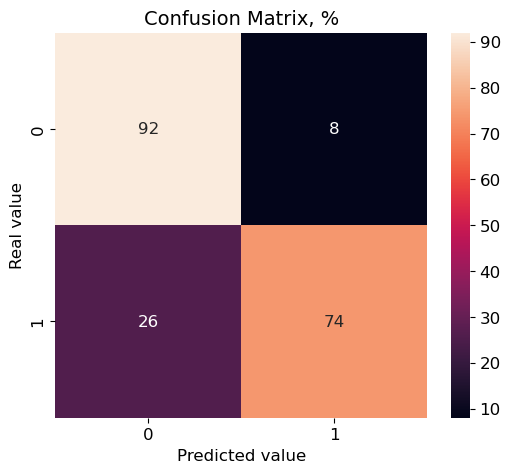

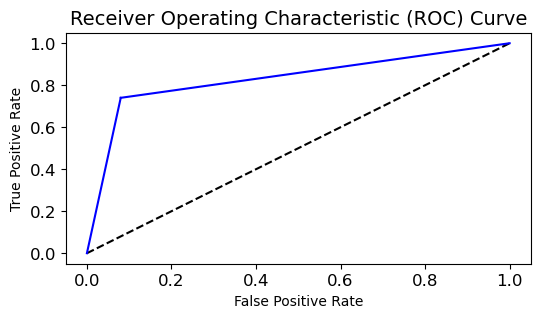

In [293]:
confusion_matrix_and_roc_curve(results_df=results, loc=217)

## Conclusion

Positive tweets often include such words as smile, love, happy, like, life, etc. Whereas, negative tweets incorporate hate, racism, allahsoil, black, trump, and so on.

BernoulliNB classifier with CountVectorizer showed absolutely dissatisfactory results.

The highest recall achieved using MultinomialNB and ComplementNB classifiers is 0.822 , but with precision of 0.331, which is quite low.

So far, the results that seem to be the best are as follows: recall - 0.737, precision - 0.407, F1 - 0.524.

These values are obtained with the following parameters:

MultinomialNB classifier {'alpha': 1.0, 'fit_prior': True}, CountVectorizer {'binary': True, 'ngram_range': (1, 1)} ('token_pattern' included emoji), ADASYN(random_state=42) and

ComplementNB classifier {'alpha': 1.0}, CountVectorizer {'binary': True, 'ngram_range': (1, 1)} ('token_pattern' included emoji), ADASYN(random_state=42)

# Naive Bayes Classifier with TF-IDF

The approach will be similar to the previous chapter, but without imbalanced classes as they showed results worse than ADASYN and SMOTE. Besides, let us try consider not only unigrams and bigrams, but trigrams as well.

In [316]:
vectorizer_param_grid = {'binary': [True, False],
                         'ngram_range': [(1,1), (1,2), (1,3)],
                         'token_pattern': [token_pattern]}

In [318]:
# Running the grid search with cross-validation for TfidfVectorizer with SMOTE and ADASYN
imbalance_algorithms = [SMOTE(random_state=42), ADASYN(random_state=42)]
bayes_2 = {}
keys = ['smote', 'adasyn']
results_2 = pd.DataFrame()

for i in range(len(imbalance_algorithms)):
    bayes_2[keys[i]] = BayesNLP(df, cv=5)
    bayes_2[keys[i]].grid_search_cv(classifiers = classifiers,
                         classifier_param_grids = classifier_param_grids,
                         vectorizer = TfidfVectorizer,
                         vectorizer_param_grid = vectorizer_param_grid,
                         imbalance_algorithm = imbalance_algorithms[i])
    results_2 = pd.concat([results_2, bayes_2[keys[i]]._cv_results], ignore_index=True)

Total number of iterations: 162.
Iteration 1 out of 162 is finished.
Iteration 2 out of 162 is finished.
Iteration 3 out of 162 is finished.
Iteration 4 out of 162 is finished.
Iteration 5 out of 162 is finished.
Iteration 6 out of 162 is finished.
Iteration 7 out of 162 is finished.
Iteration 8 out of 162 is finished.
Iteration 9 out of 162 is finished.
Iteration 10 out of 162 is finished.
Iteration 11 out of 162 is finished.
Iteration 12 out of 162 is finished.
Iteration 13 out of 162 is finished.
Iteration 14 out of 162 is finished.
Iteration 15 out of 162 is finished.
Iteration 16 out of 162 is finished.
Iteration 17 out of 162 is finished.
Iteration 18 out of 162 is finished.
Iteration 19 out of 162 is finished.
Iteration 20 out of 162 is finished.
Iteration 21 out of 162 is finished.
Iteration 22 out of 162 is finished.
Iteration 23 out of 162 is finished.
Iteration 24 out of 162 is finished.
Iteration 25 out of 162 is finished.
Iteration 26 out of 162 is finished.
Iteration 27 o

In [338]:
# Saving the results
results_2.to_csv('results_tfidfvectorizer.csv', index=False)
results_2 = pd.read_csv('results_tfidfvectorizer.csv')
results_2

,vectorizer,vectorizer_params,imbalance_algorithm,classifier,classifier_params,accuracy,precision,recall,roc_auc,f1,TN_real0_pred0,FP_real0_pred1,FN_real1_pred0,TP_real1_pred1,pos_words,neg_words
0,TfidfVectorizer,"{'binary': True, 'ngram_range': (1, 1), 'token...",SMOTE(random_state=42),MultinomialNB,"{'alpha': 1.0, 'fit_prior': True}",0.904,0.404,0.852,0.880,0.548,0.91,0.09,0.15,0.85,"{'get', 'people', 'see', 'make', 'life', 'user...","{'call', 'trump', 'people', 'racist', 'white',..."
1,TfidfVectorizer,"{'binary': True, 'ngram_range': (1, 1), 'token...",SMOTE(random_state=42),MultinomialNB,"{'alpha': 1.0, 'fit_prior': False}",0.904,0.404,0.852,0.880,0.548,0.91,0.09,0.15,0.85,"{'get', 'people', 'see', 'make', 'life', 'user...","{'call', 'trump', 'people', 'racist', 'white',..."
2,TfidfVectorizer,"{'binary': True, 'ngram_range': (1, 1), 'token...",SMOTE(random_state=42),MultinomialNB,"{'alpha': 2.0, 'fit_prior': True}",0.894,0.380,0.869,0.882,0.528,0.90,0.10,0.13,0.87,"{'get', 'people', 'see', 'make', 'life', 'user...","{'call', 'trump', 'people', 'racist', 'white',..."
3,TfidfVectorizer,"{'binary': True, 'ngram_range': (1, 1), 'token...",SMOTE(random_state=42),MultinomialNB,"{'alpha': 2.0, 'fit_prior': False}",0.894,0.380,0.869,0.882,0.528,0.90,0.10,0.13,0.87,"{'get', 'people', 'see', 'make', 'life', 'user...","{'call', 'trump', 'people', 'racist', 'white',..."
4,TfidfVectorizer,"{'binary': True, 'ngram_range': (1, 1), 'token...",SMOTE(random_state=42),MultinomialNB,"{'alpha': 3.0, 'fit_prior': True}",0.888,0.366,0.873,0.881,0.516,0.89,0.11,0.13,0.87,"{'get', 'people', 'see', 'make', 'life', 'user...","{'call', 'trump', 'people', 'racist', 'white',..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,TfidfVectorizer,"{'binary': False, 'ngram_range': (1, 3), 'toke...",ADASYN(random_state=42),BernoulliNB,"{'alpha': 3.0, 'fit_prior': True, 'binarize': ...",0.955,0.935,0.364,0.681,0.523,1.00,0.00,0.64,0.36,"{'get', 'people', 'see', 'make', 'life', 'user...","{'call', 'trump', 'get', 'people', 'racist', '..."
320,TfidfVectorizer,"{'binary': False, 'ngram_range': (1, 3), 'toke...",ADASYN(random_state=42),BernoulliNB,"{'alpha': 3.0, 'fit_prior': True, 'binarize': ...",0.245,0.056,0.799,0.501,0.104,0.20,0.80,0.19,0.81,"{'🙄 🙄', '⭐', 'day user', 'make', '😹', '😂', '😃'...","{'turn resignation', 'agree', 'deeper', 'user ..."
321,TfidfVectorizer,"{'binary': False, 'ngram_range': (1, 3), 'toke...",ADASYN(random_state=42),BernoulliNB,"{'alpha': 3.0, 'fit_prior': False, 'binarize':...",0.482,0.216,0.916,0.683,0.274,0.45,0.55,0.08,0.92,"{'get', 'thankful', 'see', 'make', 'life', 'us...","{'trump', 'people', 'white', 'racist', 'hate',..."
322,TfidfVectorizer,"{'binary': False, 'ngram_range': (1, 3), 'toke...",ADASYN(random_state=42),BernoulliNB,"{'alpha': 3.0, 'fit_prior': False, 'binarize':...",0.955,0.936,0.363,0.681,0.523,1.00,0.00,0.64,0.36,"{'get', 'people', 'see', 'make', 'life', 'user...","{'call', 'trump', 'get', 'people', 'racist', '..."


## Analysis of Results

In [345]:
print(f'Positive words: {results_2.loc[10]['pos_words']}\n')
print(f'Negative words: {results_2.loc[10]['neg_words']}')

Positive words: {'get', 'see', 'make', 'life', 'user', 'go', 'amp', '️', 'love', 'smile', 'happy', 'father', 'time', 'user user', 'like', 'new', 'father day', 'day', 'positive', 'im', 'today'}

Negative words: {'call', 'trump', 'people', 'white', 'racist', 'hate', 'woman', 'latest', 'sex', 'black', 'amp', 'user allahsoil', 'comment', 'obama', 'say', 'emiratis', 'thank user', 'user user', 'stop', 'like', 'racism', 'allahsoil', 'bigot', 'america', 'thats', 'user'}


The positive and negative marker words are similar to those from the previous chapter.

In [378]:
results_2[(results_2['classifier'] == 'BernoulliNB') & (results_2['precision'] > 0.4)].sort_values('recall', ascending=False).head(2)

,vectorizer,vectorizer_params,imbalance_algorithm,classifier,classifier_params,accuracy,precision,recall,roc_auc,f1,TN_real0_pred0,FP_real0_pred1,FN_real1_pred0,TP_real1_pred1,pos_words,neg_words
72,TfidfVectorizer,"{'binary': True, 'ngram_range': (1, 2), 'token...",SMOTE(random_state=42),BernoulliNB,"{'alpha': 1.0, 'fit_prior': True, 'binarize': ...",0.903,0.403,0.869,0.887,0.55,0.91,0.09,0.13,0.87,"{'get', 'see', 'make', 'life', 'user', 'go', '...","{'call', 'trump', 'people', 'white', 'racist',..."
75,TfidfVectorizer,"{'binary': True, 'ngram_range': (1, 2), 'token...",SMOTE(random_state=42),BernoulliNB,"{'alpha': 1.0, 'fit_prior': False, 'binarize':...",0.903,0.403,0.869,0.887,0.55,0.91,0.09,0.13,0.87,"{'get', 'see', 'make', 'life', 'user', 'go', '...","{'call', 'trump', 'people', 'white', 'racist',..."


This time, BernoulliNB classifier shows good metrics. 

Assuming we consider only results with precision > 0.4, the highest recall is 0.869 with the following parameters:

BernoulliNB classifier {'alpha': 1.0, 'fit_prior': True, 'binarize': None}, TfidfVectorizer {'binary': True, 'ngram_range': (1, 2)} ('token_pattern' included emoji), SMOTE(random_state=42).

In [387]:
results_2[(results_2['precision'] > 0.4)].sort_values('recall', ascending=False).head(1)

,vectorizer,vectorizer_params,imbalance_algorithm,classifier,classifier_params,accuracy,precision,recall,roc_auc,f1,TN_real0_pred0,FP_real0_pred1,FN_real1_pred0,TP_real1_pred1,pos_words,neg_words
168,TfidfVectorizer,"{'binary': True, 'ngram_range': (1, 2), 'token...",ADASYN(random_state=42),MultinomialNB,"{'alpha': 1.0, 'fit_prior': True}",0.903,0.402,0.874,0.89,0.551,0.9,0.1,0.12,0.88,"{'get', 'see', 'make', 'life', 'user', 'go', '...","{'call', 'trump', 'people', 'white', 'racist',..."


Among all, the highest recall for precision > 0.4 is 0.874 obtained using MultinomialNB {'alpha': 1.0, 'fit_prior': True}, TfidfVectorizer {'binary': True, 'ngram_range': (1, 2)} ('token_pattern' included emoji), ADASYN(random_state=42).

Let us build the confusion matrix and ROC curve for it.

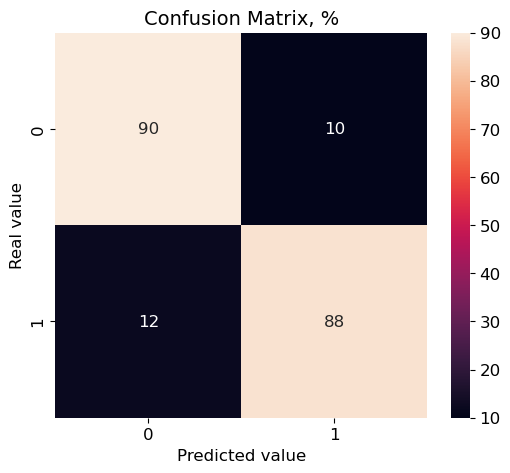

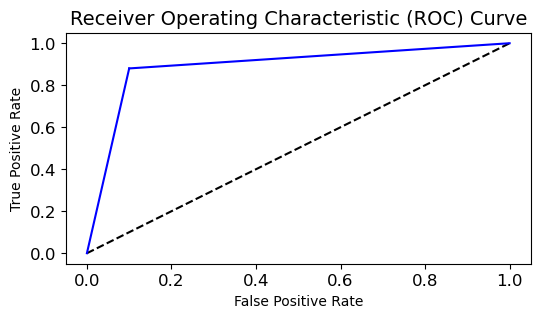

In [413]:
confusion_matrix_and_roc_curve(results_df=results_2, loc=168)

In [390]:
results_2[(results_2['precision'] > 0.5)].sort_values('recall', ascending=False).head(1)

,vectorizer,vectorizer_params,imbalance_algorithm,classifier,classifier_params,accuracy,precision,recall,roc_auc,f1,TN_real0_pred0,FP_real0_pred1,FN_real1_pred0,TP_real1_pred1,pos_words,neg_words
67,TfidfVectorizer,"{'binary': True, 'ngram_range': (1, 1), 'token...",SMOTE(random_state=42),BernoulliNB,"{'alpha': 3.0, 'fit_prior': True, 'binarize': ...",0.94,0.549,0.717,0.837,0.621,0.96,0.04,0.28,0.72,"{'get', 'people', 'see', 'make', 'life', 'user...","{'call', 'trump', 'get', 'people', 'make', 'ra..."


Using BernoulliNB classifier {'alpha': 3.0, 'fit_prior': True, 'binarize': 0.0}, TfidfVectorizer {'binary': True, 'ngram_range': (1, 1)} ('token_pattern' included emoji), SMOTE(random_state=42) the recall of 0.717 with the precision of 0.549 was obtained. 

This results in type I mistakes take place only in 4% of cases (FP). 

Such an algorithm seems to be promising if we play with the threshold of classification and find the most optimal balance between FP and TP rates.

Let us build the confusion matrix and ROC curve for it as well.

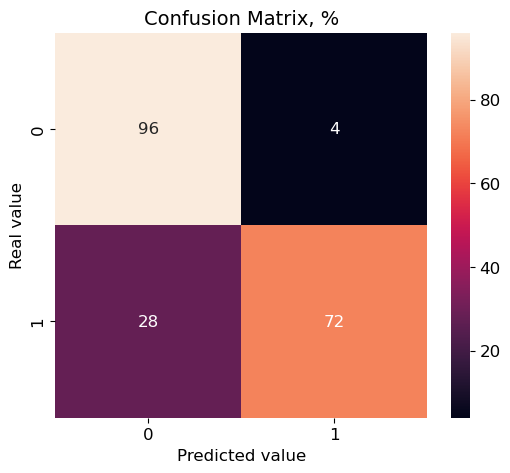

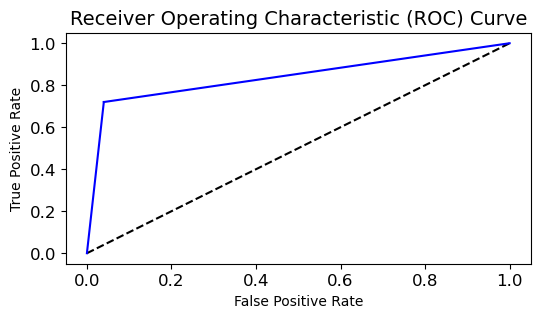

In [410]:
confusion_matrix_and_roc_curve(results_df=results_2, loc=67)

## Conclusion

Overall, TF-IDF classifier performs much better compared to CountVectorizer.

In most cases, introduction of trigrams did not improve metrics anyhow, but noticeably slowed down the work.

The highest recall for precision > 0.4 is 0.874 obtained using MultinomialNB {'alpha': 1.0, 'fit_prior': True}, TfidfVectorizer {'binary': True, 'ngram_range': (1, 2)} ('token_pattern' included emoji), ADASYN(random_state=42). There are 10% of type I mistakes (FP) in this case.

The highest recall for precision > 0.5 is 0.717 obtained usingBernoulliNB classifier {'alpha': 3.0, 'fit_prior': True, 'binarize': 0.0}, TfidfVectorizer {'binary': True, 'ngram_range': (1, 1)} ('token_pattern' included emoji), SMOTE(random_state=42). There are 4% of type I mistakes (FP) in this case.

By manually adjusting the threshold of classification, the optimal balance between FP and TP rates can be achieved.

# Logistic Regression with TF-IDF and Matrix Dimensionality Reduction

Let us see if we can obtain any decent results using Logistic Regression preceeded by matrix dimensionality reduction.

In [33]:
vectorizer_params = {'binary': False,
                     'ngram_range': (1,3),
                     'token_pattern': token_pattern}

In [34]:
# Vectorising data
svd_x = df['tweet']
svd_y = df['label']

vectorizer = TfidfVectorizer(**vectorizer_params)
vectorizer.fit(svd_x)
svd_x = vectorizer.transform(svd_x)

The shape of the obtained matrix is (29530, 388296).

In [76]:
svd_x_train, svd_x_test, svd_y_train, svd_y_test = train_test_split(svd_x, svd_y, test_size=0.2, random_state=42)

In [78]:
pipe = Pipeline(steps=[    
    ('tr', TruncatedSVD()), # Reducing matrix dimensionality
    ('pf', PolynomialFeatures(include_bias=False)),  # Creating polynomial features
    ('log_reg', LogisticRegression(penalty='elasticnet', solver='saga'))  # Logistic Regression with ElasticNet (regularisation combining L1 and L2)
])

param_grid = {
    'pf__degree': [1, 2],  # Polynomial features degree    
    'tr__n_components': [2, 5, 10],  # Dimensionality of the feature matrix 
    'log_reg__class_weight': ['balanced'],  # Handling class imbalance
    'log_reg__l1_ratio': [0.5],  # L1 ratio for ElasticNet
}

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best recall score:  0.9052959501557633
Best parameters for recall:  {'log_reg__class_weight': 'balanced', 'log_reg__l1_ratio': 0.5, 'pf__degree': 1, 'tr__n_components': 10}


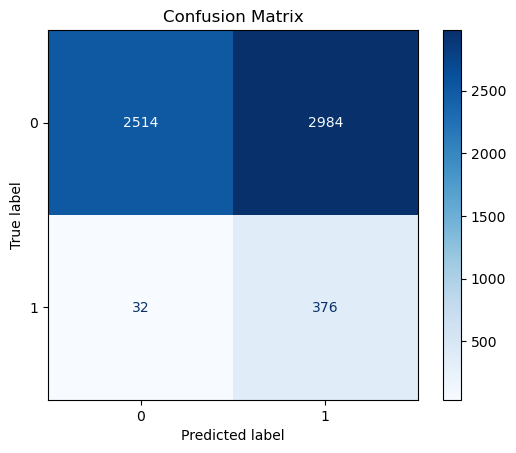

--------------------
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best precision score:  0.11525782299186353
Best parameters for precision:  {'log_reg__class_weight': 'balanced', 'log_reg__l1_ratio': 0.5, 'pf__degree': 2, 'tr__n_components': 2}


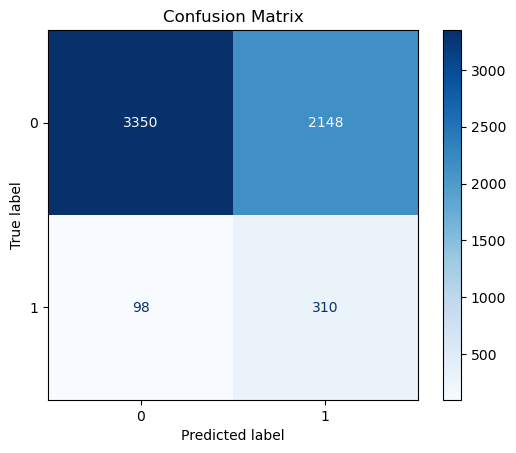

--------------------
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best roc_auc score:  0.769405468137367
Best parameters for roc_auc:  {'log_reg__class_weight': 'balanced', 'log_reg__l1_ratio': 0.5, 'pf__degree': 1, 'tr__n_components': 10}


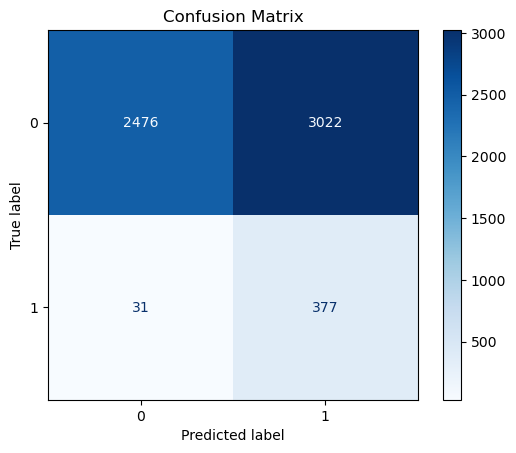

--------------------
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best f1 score:  0.2023402429219691
Best parameters for f1:  {'log_reg__class_weight': 'balanced', 'log_reg__l1_ratio': 0.5, 'pf__degree': 2, 'tr__n_components': 10}


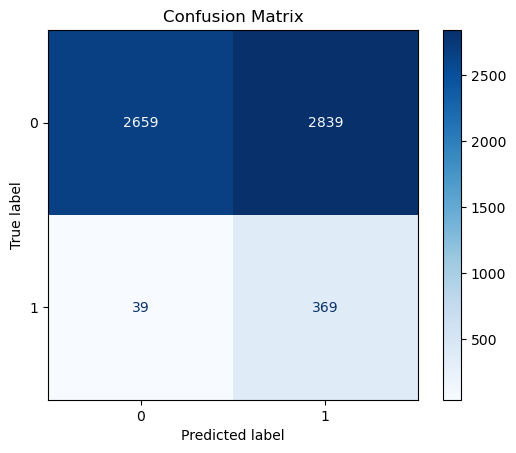

--------------------


In [86]:
scorings = ['recall', 'precision', 'roc_auc', 'f1']
for scoring in scorings:
    grid_search = GridSearchCV(pipe, param_grid, cv=5, verbose=1, scoring=scoring, n_jobs=4)
    grid_search.fit(svd_x_train, svd_y_train)
    print(f"Best {scoring} score: ", grid_search.best_score_) 
    print(f"Best parameters for {scoring}: ", grid_search.best_params_)

    # Using the best estimator to predict on the test set
    best_model = grid_search.best_estimator_
    svd_y_pred = best_model.predict(svd_x_test)

    # Generating the confusion matrix
    cm = confusion_matrix(svd_y_test, svd_y_pred)
    
    # Displaying the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()
    
    print('-'*20) 

## Conclusion

Logistic Regression with TF-IDF and Matrix Dimensionality Reduction performs much worse than the Naive Bayes Classifier.

Preceded by the feature matrix dimensionality reduction to 2, 5 and 10 columns Logistic Regression gave the following maximal metrics:
recall - 0.905, precision - 0.115, roc_auc - 0.769, f1 - 0.202.

Such results are dissatisfactory and cannot be utilised in practice because of the high number of type I mistakes (FP).

Theoretically, we can play with parameters, classification threshold and increase the dimension of the matrix, but I doubt that it can outperform the Naive Bayes Classifier. 

# General conclusion

In this notebook, I tested several approached to twitter sentiment analysis: Naive Bayes Classifier with the Bag of Words, Naive Bayes Classifier with TF-IDF, Logistic Regression with TF-IDF and Matrix Dimensionality Reduction.

-----

Positive tweets often include such words as smile, love, happy, like, life, etc.

Negative tweets incorporate hate, racism, allahsoil, black, trump, and so on.

Emojis present in tweets were among positive word indicators of some Naive Bayes algorithms.

There is no noticeable correlation between punctuation marks and the target variable, but anyway it could be a subject of further research.

-----------

BernoulliNB classifier together with CountVectorizer showed absolutely dissatisfactory results.

The best metrics obtained using CountVectorizer: recall - 0.737, precision - 0.407, F1 - 0.524.

The best parameters are:

MultinomialNB classifier {'alpha': 1.0, 'fit_prior': True}, CountVectorizer {'binary': True, 'ngram_range': (1, 1)} ('token_pattern' included emoji), ADASYN(random_state=42) and

ComplementNB classifier {'alpha': 1.0}, CountVectorizer {'binary': True, 'ngram_range': (1, 1)} ('token_pattern' included emoji), ADASYN(random_state=42)

----------

TF-IDF classifier performs much better compared to CountVectorizer.

In most cases, introduction of trigrams did not improve metrics anyhow, but noticeably slowed down the work.

The highest recall for precision > 0.4 is 0.874 obtained using MultinomialNB {'alpha': 1.0, 'fit_prior': True}, TfidfVectorizer {'binary': True, 'ngram_range': (1, 2)} ('token_pattern' included emoji), ADASYN(random_state=42). There are 10% of type I mistakes (FP) in this case.

The highest recall for precision > 0.5 is 0.717 obtained using BernoulliNB classifier {'alpha': 3.0, 'fit_prior': True, 'binarize': 0.0}, TfidfVectorizer {'binary': True, 'ngram_range': (1, 1)} ('token_pattern' included emoji), SMOTE(random_state=42). There are 4% of type I mistakes (FP) in this case.

By manually adjusting the threshold of classification, the optimal balance between FP and TP rates can be achieved.

-----------

Both ADASYN and SMOTE have proven themselves well in NLP.

------------

Logistic Regression with TF-IDF and Matrix Dimensionality Reduction performs much worse than the Naive Bayes Classifier and gave the following maximal metrics: recall - 0.905, precision - 0.115, roc_auc - 0.769, f1 - 0.202.

Such results cannot be utilised in practice because of the high number of type I mistakes (FP).